# **Shivam Krishna Mishra 20230802060 Lab08**

In [2]:
import os, time, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import cv2

# Utilities
def seed_everything(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

def ensure_dir(path):
    Path(path).parent.mkdir(parents=True, exist_ok=True)

def draw_boxes_on_image_cv2(img_bgr, boxes, labels=None, scores=None, score_thresh=0.3, class_names=None, color=(0,255,0)):
    img = img_bgr.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, box in enumerate(boxes):
        x1,y1,x2,y2 = map(int, box)
        sc = float(scores[i]) if scores is not None else None
        if sc is not None and sc < score_thresh:
            continue
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label_text = ""
        if labels is not None:
            lab = int(labels[i])
            if class_names and isinstance(class_names, (list,tuple)) and lab < len(class_names):
                label_text = class_names[lab]
            else:
                label_text = str(lab)
        if sc is not None:
            label_text = f"{label_text} {sc:.2f}"
        cv2.putText(img, label_text, (x1, max(15,y1-5)), font, 0.6, color, 2, cv2.LINE_AA)
    return img

# COCO labels for Faster R-CNN display
COCO_LABELS = [
    '__background__', 'person','bicycle','car','motorcycle','airplane','bus','train','truck','boat',
    'traffic light','fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep',
    'cow','elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
    'skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard','tennis racket',
    'bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot',
    'hot dog','pizza','donut','cake','chair','couch','potted plant','bed','dining table','toilet','tv','laptop','mouse',
    'remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','book','clock','vase','scissors',
    'teddy bear','hair drier','toothbrush'
]


In [3]:
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return trainloader, testloader, trainset.classes

def build_resnet18_for_cifar(num_classes=10, pretrained=True, device="cpu"):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [4]:
def train_resnet(model, trainloader, testloader, device, epochs=10, lr=1e-3, out_path="resnet18_cifar10.pth"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
    best_val_acc = 0.0
    ensure_dir(out_path)

    for epoch in range(epochs):
        model.train()
        running_loss=0.; running_correct=0; running_total=0
        loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} [train]")
        for images, labels in loop:
            images = images.to(device); labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            running_correct += (preds == labels).sum().item()
            running_total += images.size(0)
        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total

        # validation
        model.eval()
        val_loss=0.; val_correct=0; val_total=0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device); labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += images.size(0)
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        scheduler.step()

        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc); history["val_acc"].append(val_acc)
        tqdm.write(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), out_path)
            tqdm.write(f"Saved best model to {out_path} (val_acc={best_val_acc:.4f})")
    return history, best_val_acc

def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train_loss"); plt.plot(history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="train_acc"); plt.plot(history["val_acc"], label="val_acc"); plt.legend(); plt.title("Accuracy")
    plt.show()

def evaluate_classifier(model, dataloader, device, class_names=None):
    model.eval()
    all_preds=[]; all_labels=[]
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Eval"):
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.append(preds.cpu().numpy()); all_labels.append(labels.numpy())
    all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
    n = len(class_names) if class_names else int(all_labels.max()+1)
    cm = np.zeros((n,n), dtype=int)
    for t,p in zip(all_labels, all_preds): cm[t,p]+=1
    per_class_acc = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
    overall = (all_preds==all_labels).mean()
    print("Overall acc:", overall)
    if class_names:
        for i,name in enumerate(class_names): print(f"{name}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")
    plt.figure(figsize=(7,6)); plt.imshow(cm, cmap='Blues'); plt.colorbar()
    if class_names:
        plt.xticks(np.arange(len(class_names)), class_names, rotation=90); plt.yticks(np.arange(len(class_names)), class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    return overall, per_class_acc, cm


In [5]:
def load_fasterrcnn(device="cpu", pretrained=True):
    model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT if pretrained else None)
    model.to(device).eval()
    return model

def run_detector_on_image(model, image_path, device="cpu", conf_thresh=0.5, max_boxes=50):
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError("Image not found: " + image_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    tensor = transforms.ToTensor()(rgb).to(device)
    with torch.no_grad():
        out = model([tensor])[0]
    boxes = out['boxes'].cpu().numpy()
    scores = out['scores'].cpu().numpy()
    labels = out['labels'].cpu().numpy()
    keep = scores >= conf_thresh
    boxes = boxes[keep][:max_boxes]; scores = scores[keep][:max_boxes]; labels = labels[keep][:max_boxes]
    return bgr, boxes, labels, scores

def visualize_and_save_detections(image_bgr, boxes, labels, scores, out_path="detections.jpg", score_thresh=0.4):
    img_out = draw_boxes_on_image_cv2(image_bgr, boxes, labels, scores, score_thresh, COCO_LABELS)
    cv2.imwrite(out_path, img_out)
    # show in notebook
    img_rgb = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,10)); plt.imshow(img_rgb); plt.axis('off'); plt.show()
    print("Saved:", out_path)


Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 48.4MB/s]
Epoch 1/3 [train]: 100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch 1: train_loss=1.0343, train_acc=0.6474, val_loss=0.8408, val_acc=0.7203
Saved best model to resnet18_cifar10_demo.pth (val_acc=0.7203)


Epoch 2/3 [train]: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s]


Epoch 2: train_loss=0.7476, train_acc=0.7460, val_loss=0.7158, val_acc=0.7562
Saved best model to resnet18_cifar10_demo.pth (val_acc=0.7562)


Epoch 3/3 [train]: 100%|██████████| 391/391 [00:21<00:00, 18.05it/s]


Epoch 3: train_loss=0.6527, train_acc=0.7780, val_loss=0.6590, val_acc=0.7744
Saved best model to resnet18_cifar10_demo.pth (val_acc=0.7744)


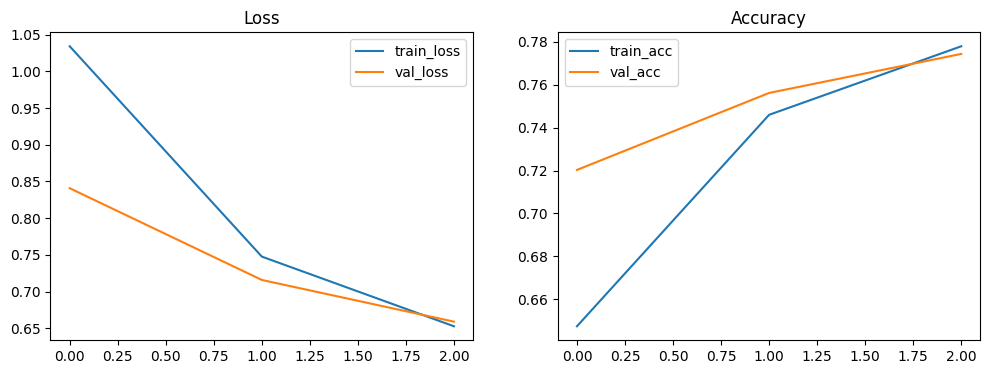

Best val acc (demo): 0.7744


In [6]:
# Choose device and seed
seed_everything(0)
device = get_device()
print("Device:", device)

trainloader, testloader, class_names = get_cifar10_dataloaders(batch_size=128, num_workers=2)
model = build_resnet18_for_cifar(num_classes=len(class_names), pretrained=True, device=device)
history, best = train_resnet(model, trainloader, testloader, device, epochs=3, lr=1e-3, out_path="resnet18_cifar10_demo.pth")
plot_history(history)
print("Best val acc (demo):", best)


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.09it/s]


Overall acc: 0.7744
airplane: 0.7470 (n=1000)
automobile: 0.8860 (n=1000)
bird: 0.6710 (n=1000)
cat: 0.7080 (n=1000)
deer: 0.7600 (n=1000)
dog: 0.4140 (n=1000)
frog: 0.8940 (n=1000)
horse: 0.8780 (n=1000)
ship: 0.9100 (n=1000)
truck: 0.8760 (n=1000)


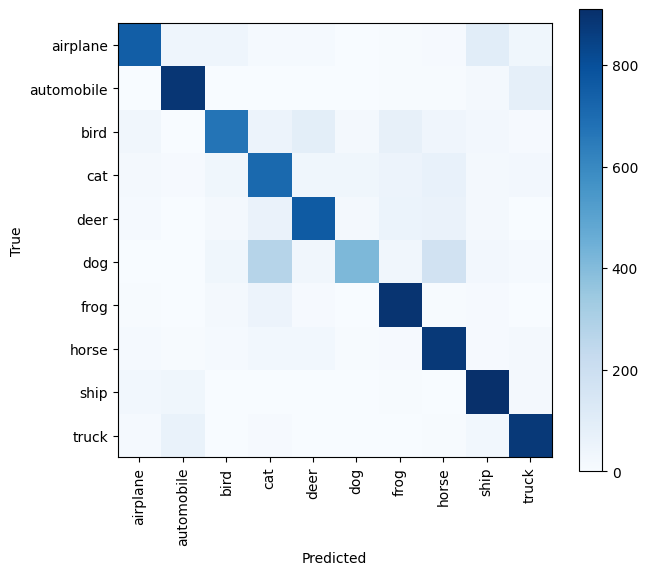

(np.float64(0.7744),
 array([0.747, 0.886, 0.671, 0.708, 0.76 , 0.414, 0.894, 0.878, 0.91 ,
        0.876]),
 array([[747,  40,  42,  11,  12,   1,   5,  10,  97,  35],
        [  2, 886,   3,   3,   0,   0,   5,   4,  17,  80],
        [ 30,   3, 671,  50,  89,  15,  72,  37,  24,   9],
        [ 19,   8,  35, 708,  34,  34,  53,  69,  18,  22],
        [ 11,   1,  21,  60, 760,  16,  54,  59,  16,   2],
        [  2,   2,  34, 272,  31, 414,  31, 177,  23,  14],
        [  4,   2,  21,  50,  10,   2, 894,   7,   8,   2],
        [ 12,   4,  11,  25,  25,   7,   8, 878,   9,  21],
        [ 27,  33,   3,   3,   1,   0,   4,   2, 910,  17],
        [ 12,  63,   1,   8,   1,   3,   2,   7,  27, 876]]))

In [7]:
device = get_device()
trainloader, testloader, class_names = get_cifar10_dataloaders(batch_size=128, num_workers=2)
model = build_resnet18_for_cifar(num_classes=len(class_names), pretrained=True, device=device)
model.load_state_dict(torch.load("resnet18_cifar10_demo.pth", map_location=device))
evaluate_classifier(model, testloader, device, class_names=class_names)


Saving uhjbj.webp to uhjbj (1).webp
Uploaded: uhjbj (1).webp


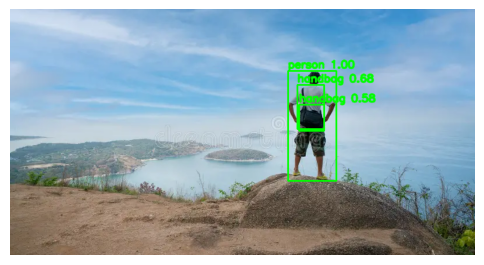

Saved: detections_out.jpg


In [14]:
# Run this cell to upload an image file interactively in Colab
from google.colab import files
uploaded = files.upload()  # click to upload image(s) from your machine

# Suppose you uploaded 'sample.jpg', set image_path accordingly:
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)

device = get_device()
det_model = load_fasterrcnn(device=device, pretrained=True)
bgr, boxes, labels, scores = run_detector_on_image(det_model, image_path, device=device, conf_thresh=0.45)
visualize_and_save_detections(bgr, boxes, labels, scores, out_path="detections_out.jpg", score_thresh=0.45)
